<a href="https://colab.research.google.com/github/gsiraji/omicsPractice/blob/main/genpals_tutorial2_Celltype_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copy this notebook!

First please copy this notebook to your own Google drive, you won't be able to run it otherwise! Use **File > Save a Copy in Drive**.




# Install required libraries

In [ ]:
# note: more recent versions of scanpy are causing matplotlib issues wtih google colab!!!
! pip install 'pandas==1.1.5' 'scanpy[leiden]==1.6.1' 'scrublet==0.2.3' 'numba==0.52' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 119.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Make a shortcut to the data folder

Before being able to run the rest of this notebook, you must give colab access to the [data directory](https://drive.google.com/drive/folders/1_ZKcxAGHzKR-WM3l3Ia1g7Ikbqt1f2FK?usp=sharing) by:

1. Follow the above link. Right click the `genpals_data` directory and select `Add shortcut to Drive` to make the data accessible from your drive.

2. Mount your drive by opening the left panel on colab, going to the `Files` menu, and selecting `Mount Drive` at the top right (i**con looks like a folder with the Google Drive logo**). 

3. Run the block below 

4. Once you run it and sign in with your Google account, hit the directory refresh button (icon looks like a folder with a refresh symbol on it) on the bar at the left.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Read downsampled dataset

For the purposes of this module, we'll only use one sample's worth of cells (~4k cells) so that we can quickly test out different parameters for dimensionality reduction and unsupervised learning.

In [ ]:
import scanpy as sc 
import anndata 
import numpy as np 
import pandas as pd 

from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context
import os

In [ ]:
data_dir = "/content/drive/MyDrive/genpals_data/Zhou_2020/"
adata = sc.read('{}adata_unprocessed_AD11.h5ad'.format(data_dir))

First filter and do QC

In [ ]:
adata.shape

(3786, 28392)

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=400)

In [ ]:
adata.shape

(3722, 21053)

Save counts in separate anndata layer:

In [ ]:
adata.layers['counts'] = adata.X.copy() # The copy in python creates a new object, without copy it just points the variable name to the same object

Now we will normalize data (accounting for variable library depth)

In [ ]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

Now do dimensionality reduction: First run feature selection, then PCA, then run kNN to create a graph, then do UMAP and clustering on the PCs

In [ ]:
# identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# compute the qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# run PCA
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=True)

# run UMAP and clustering
sc.pp.neighbors(adata, metric='cosine')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

Let's plot:

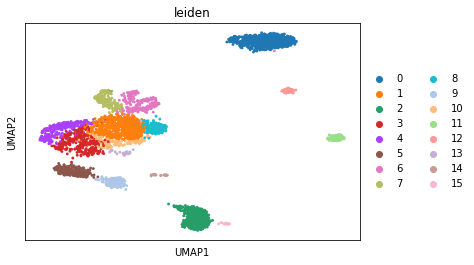

In [ ]:
sc.pl.umap(adata, color='leiden')

# Celltype ID: relies on using known marker genes

We know that this is brain data. Therefore what celltypes do we expect? We expect neurons, microglia, astrocyte, oligodendrocytes, oligodendrocyte progenitor cells, and endothelial cells. We can search for marker genes for these celltypes.

Very important point: when looking for marker genes, try to use single cell/neuclus papers, NOT flow cytometry papers. scRNAseq papers will have good transcriptomic makers, but it is not necessarily true that protein markers will work well to ID celltypes in single cell (and vis-versa).

Markers:
* Neurons: GRIN1
* Microglia: C1QA
* Astrocyte: AQP4
* Oligodendrocyte: MOG
* Oligodendrocyte progenitors: PDGFRA
* Endothelial cells: PECAM1




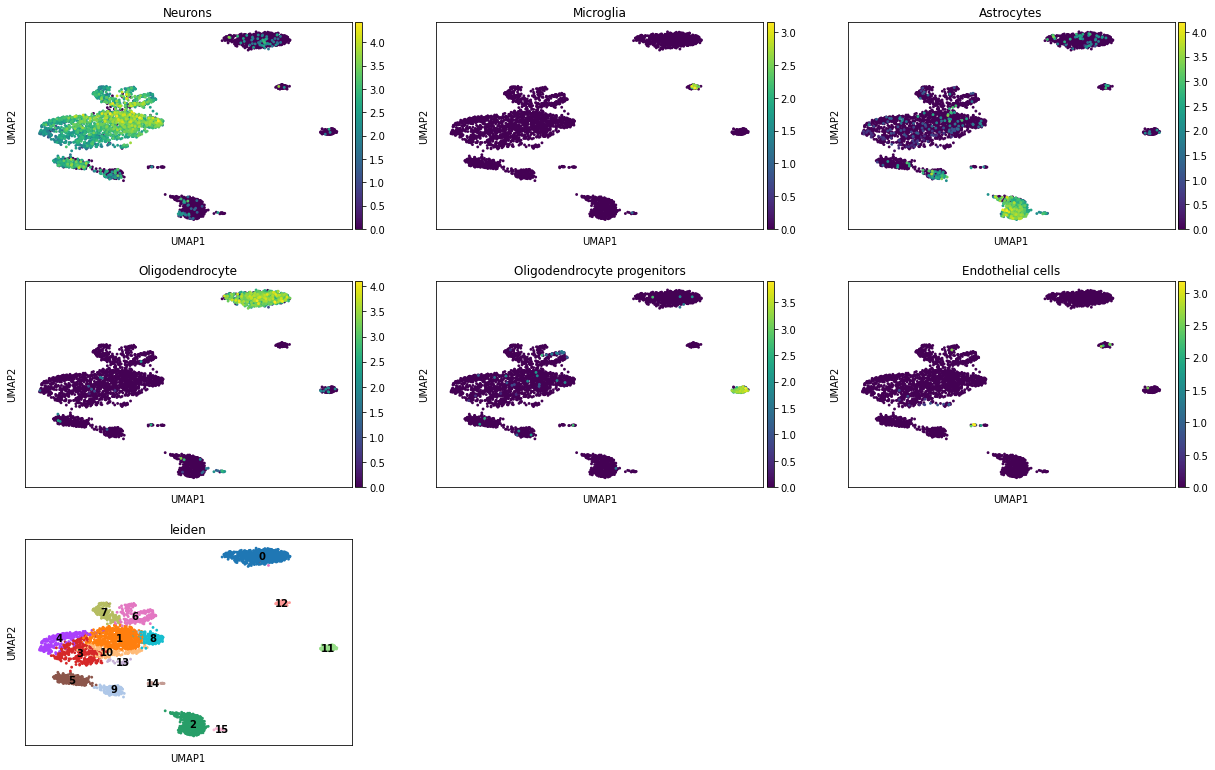

In [ ]:
sc.pl.umap(adata, color=['GRIN1', 'C1QA', 'AQP4', 'MOG', 'PDGFRA', 'PECAM1', 'leiden'], title=['Neurons', 'Microglia', 'Astrocytes', 'Oligodendrocyte', 'Oligodendrocyte progenitors', 'Endothelial cells', 'leiden'], ncols=3, legend_loc='on data')

Using the feature plots, we can already identify the celltypes in our data:

In [ ]:
map_me = {'0':'Oligodendrocyte', '1':'Neuron', '2':'Astrocyte', '3':'Neuron', '4':'Neuron', '5':'Neuron', '6':'Neuron', '7':'Neuron','8':'Neuron', '9':'Neuron', '10':'Neuron','11':'Microglia', '12':'OPC', '13':'Neuron', '14':'Endothelial cells', '15':'Astrocyte'}

adata.obs['Celltype'] = adata.obs['leiden'].map(map_me)

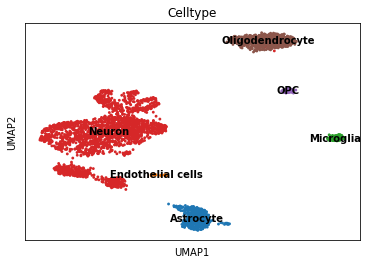

In [ ]:
sc.pl.umap(adata, color=['Celltype'], legend_loc='on data')

Important notes:
1. It's possible that some of these clusters are mis-identified -- for example, cluster 9 is expressing both Neuron and Astrocyte markers. We will refine the clustering later. 
2. It is also important to note that up until now, we have not used the clustering to do anything besides labeling the cells for easy reference. We haven't used clustering to do any sort of unsupervised analysis. 




This is sufficient for celltype ID. Once we get into cell state identification, we'll have to do statistics.

# Cell state ID: relies on differential expression of clusters

The idea is to ask the question what genes are statistically different in each cluster? We can focus on neurons as an example.

In [ ]:
neurons = adata[adata.obs['Celltype'].isin(['Neuron'])].copy()
neurons_store = neurons.copy()

Extremely important: need to redo the entire pipeline analysis (feature selection, PCA, etc.) when subsetting!

In [ ]:
# identify highly variable genes
sc.pp.highly_variable_genes(neurons, n_top_genes=3000)

# run PCA
sc.tl.pca(neurons, n_comps=50, svd_solver='arpack', use_highly_variable=True)

# run UMAP and clustering
sc.pp.neighbors(neurons, metric='cosine')
sc.tl.umap(neurons)
sc.tl.leiden(neurons, resolution=1)

In [ ]:
neurons.obs.head()

,Age,Sex,SampleID,DonorID,Batch,Original_cluster,Dataset,Region,cerad,braak,...,total_counts,total_counts_mt,pct_counts_mt,leiden,Celltype,leiden_original,leiden_1.0,leiden_0.3,leiden_0.7,leiden_1.5
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAAACCCAT-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,...,2332.456543,23.011171,0.986564,2,Neuron,1,2,0,0,3
AAACCTGCAATGTTGC-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,...,1503.066895,72.559074,4.827402,6,Neuron,9,6,5,7,6
AAACCTGGTCCTAGCG-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,...,4471.354004,35.191219,0.787037,10,Neuron,3,10,3,1,10
AAACCTGGTGTCGCTG-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,...,3823.762939,21.661709,0.566502,2,Neuron,1,2,0,4,3
AAACCTGTCACCTCGT-1_3,88.468,M,AD11,AD11,3,NaN,Zhou,PFC,2,3,...,4297.545410,29.100908,0.677152,12,Neuron,4,12,1,10,12


Compare clusters before and after recalculation:

In [ ]:
neurons.obs['leiden_original'] = neurons_store.obs['leiden'].copy()

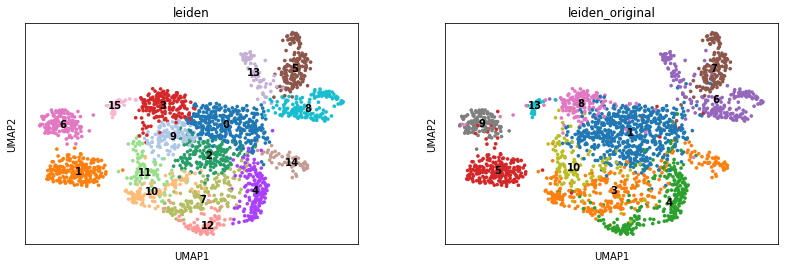

In [ ]:
sc.pl.umap(neurons, color=['leiden', 'leiden_original'], legend_loc='on data')

## Now we can do differential expression to identify the clusters

Effect size statistic is logFC, statistical test is [Mann-Whitney-U](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (aka wilcoxon). The test is performed one-vs-rest.

In [ ]:
sc.tl.rank_genes_groups(neurons, method='wilcoxon', use_raw=False, groupby='leiden') 
#NB: default test in scanpy is t-test! Do not use t-test for scRNAseq data!!!!!!

Now let's plot the differentially expressed genes.

In [ ]:
sc.tl.dendrogram(neurons, groupby='leiden')

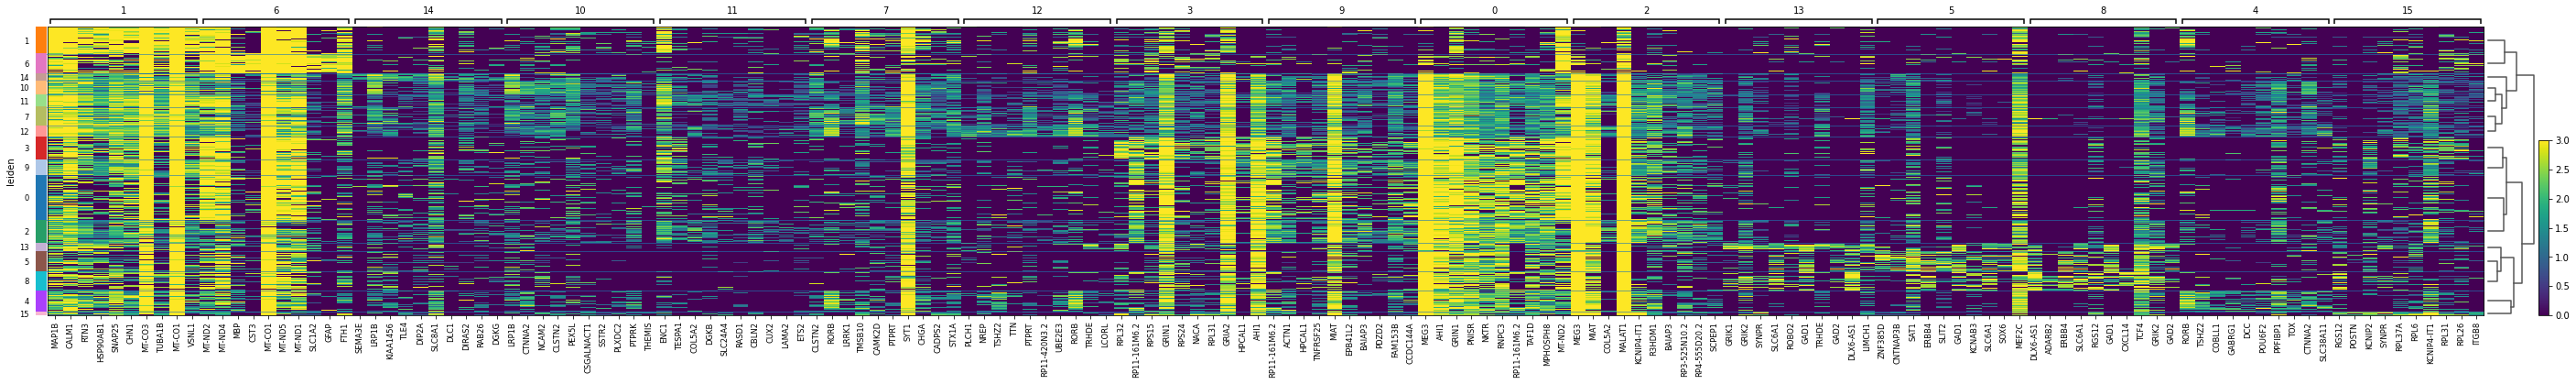

In [ ]:
sc.pl.rank_genes_groups_heatmap(neurons, groupby='leiden', cmap='viridis', show_gene_labels=True, vmax=3)

Note: The convention is to plot heatmaps using "scaled" data (mean centered and divided by standard deviation). I don't like doing this because both the relative differences and absolute differences are important. If scaled data is used, relative differences will be shown but the genes might be very lowly expressed (therefore not meaningful for markers). 

Also important: the heatmap will plot top genes, regardless of p value! So always doublecheck using sc.get.rank_genes_groups_df() (for this version of scanpy this function errors).

This plot is a little hard to read. Let's do a dotplot:

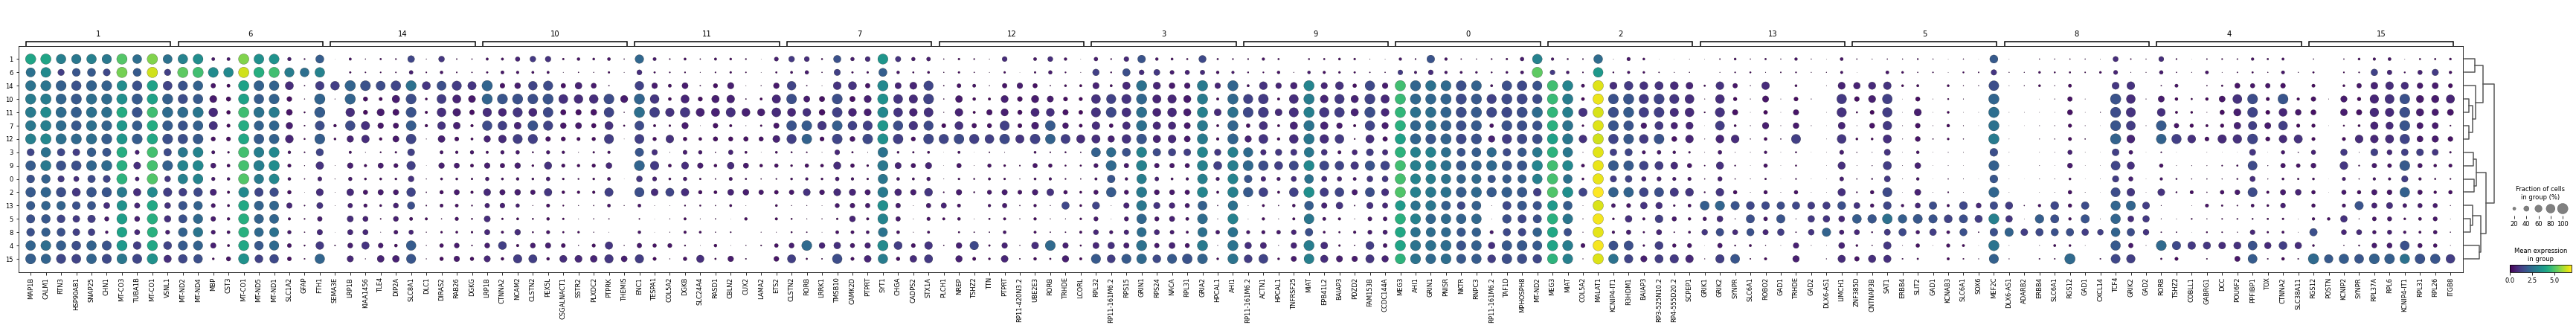

In [ ]:
sc.pl.rank_genes_groups_dotplot(neurons, cmap='viridis')

What we're seeing here is over-clustering: there are few clean clusters. In the leiden command there is a resolution parameter which we can optimize.

In [ ]:
neurons.obs['leiden_1.0'] = neurons.obs['leiden'].copy()
sc.tl.leiden(neurons, resolution=0.3, key_added='leiden_0.3')
sc.tl.leiden(neurons, resolution=0.7, key_added='leiden_0.7')
sc.tl.leiden(neurons, resolution=1.5, key_added='leiden_1.5') 

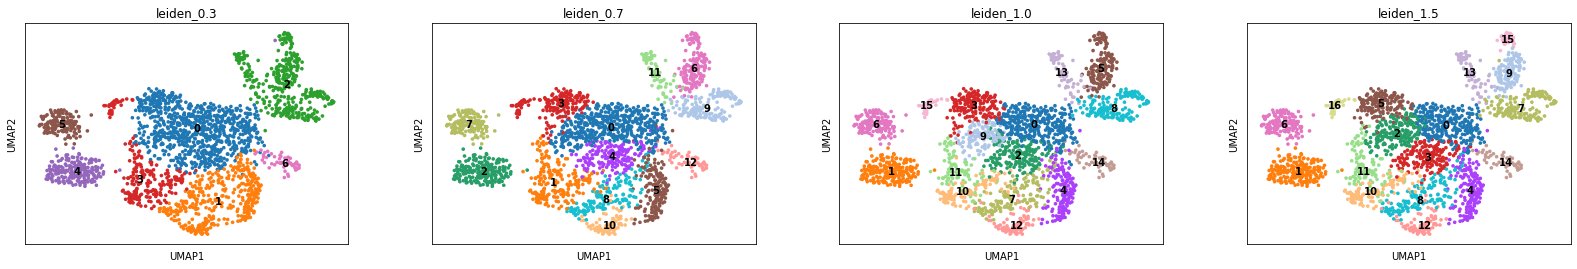

In [ ]:
sc.pl.umap(neurons, color=['leiden_0.3', 'leiden_0.7', 'leiden_1.0', 'leiden_1.5'], legend_loc='on data')

Personally, I like to go with larger clusters, and then refine. This also will make cell state ID easier due to the one-vs-rest nature of the statistical test: if there are a lot of clusters, OvR will have trouble finding good stratifying markers because there will more noise in the "rest".

In [ ]:
sc.tl.rank_genes_groups(neurons, method='wilcoxon', use_raw=False, groupby='leiden_0.3') 
#NB: default test in scanpy is t-test! Do not use t-test for scRNAseq data!!!!!!

Now let's plot the differentially expressed genes.

In [ ]:
sc.tl.dendrogram(neurons, groupby='leiden_0.3')

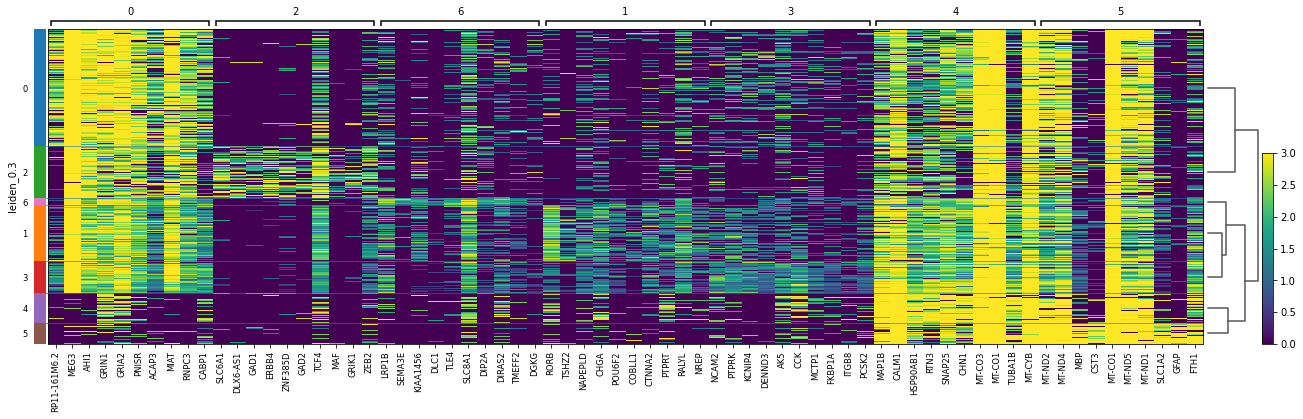

In [ ]:
sc.pl.rank_genes_groups_heatmap(neurons, groupby='leiden_0.3', cmap='viridis', show_gene_labels=True, vmax = 3) # here I am using the vmax parameter to threshold gene expression

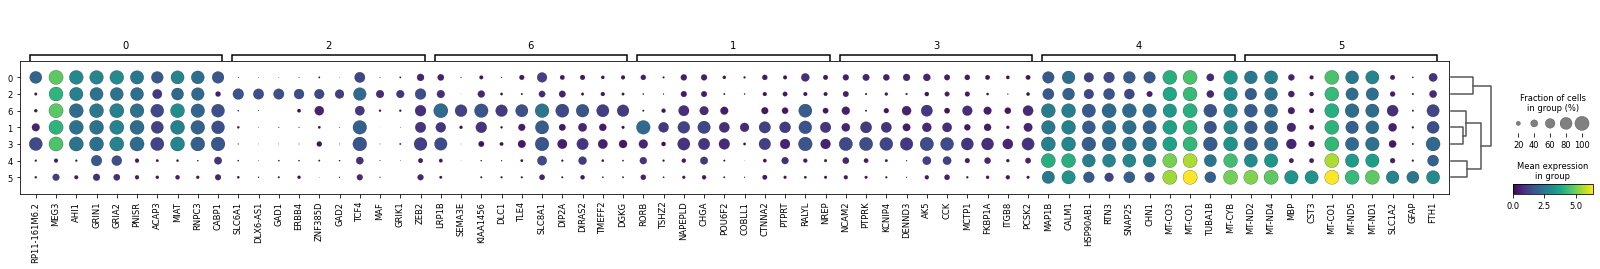

In [ ]:
sc.pl.rank_genes_groups_dotplot(neurons, cmap='viridis',groupby='leiden_0.3')

Using a combination of scRNAseq knowledge, biological knowledge and classification/statistics, we can identify a lot of these clusters.